# Ensemble Learning

This notebook contains the code which trains a **Bagging** (**B**ootstrap **Agg**regat**ing**) ensemble of the selected transformer model to compare the results with the single trained model with the same parameters. A single model can be trained and tested on the Notebook ***ModelTrainingAndTesting***. Specifically these models have been tested: **BERT**, **RoBERTa** and **Longformer**. 

Note that training Longformer may take several hours, therefore it may not be suitable for training an ensemble. Therefore, we trained an ensemble using the best-performing RoBERTa parameters. 

The details of the implementation can be found in corresponding scripts as the notebook contains high-level code. 

The code was developed using the **Kaggle** platform, but it is adapted to be run on the **Google Colab** platform.

Essential things to have to run this notebook: 
1. Set the **BASE_PATH** which is the project directory to access the dataset and the code.
2. Make sure you have the data downloaded.
3. Choose hyperparameters (including the number of models).


# Connect to the Google Drive

Firstly, connect to the Google Drive to be able to access files from there to read and store papers.

If other platform is used to run the notebook code, then comment this out. 

In [1]:
from google.colab import drive, files

colab_path = '/content/drive'
drive.mount(colab_path)

Mounted at /content/drive


# Install and Import Required Libraries for Tweets Topic Modelling

In [ ]:
#@title Install Libraries
!pip install transformers

## Import Essential Libraries

In [3]:
import os
import sys
import re
import time
import datetime
import json
import string
import requests
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, Sampler, RandomSampler, SequentialSampler, random_split, Dataset

from tqdm.auto import tqdm

# Define Paths and Import Local Scripts

Set the absolute paths for **BASE_PATH** and **DATA_PATH**.

In [4]:
BASE_PATH = "/content/drive/MyDrive/Reviewer2"

DATA_PATH = f"{BASE_PATH}/ICLR_Dataset"

module_path = os.path.abspath(BASE_PATH)
if module_path not in sys.path:
    sys.path.append(module_path)


from scripts.data_reading import get_papers_paths, extract_documents_text, subsample_documents
from scripts.ensemble import train_ensemble_models, test_ensemble_models
from scripts.evaluation_metrics import plot_ensemble_accuracy_per_number_of_models, show_ensemble_model_accuracies
from scripts.utils import get_device

# Define Constants, Hyperparameters and Configurations

In [5]:
test_size = 0.2
random_state = 42

# Hyperparameters
epochs = 10
batch_size = 16
learning_rate = 0.000055086239850275174
weight_decay = 0.01
add_paper_metadata = True
number_of_models = 2

# Choose from these models: "bert-base-cased", "roberta-base", "allenai/longformer-base-4096"
model_name = "roberta-base"

# For Longformer, this was used: MAX_TOKENS_NUMBER = 2048
# For BERT and RoBERTa, this was used: MAX_TOKENS_NUMBER = 512
MAX_TOKENS_NUMBER = 512

TEXT_SELECTION_MODES = {"INTRODUCTION_WITH_ABSTRACT": 0, 
                        "INTRODUCTION_WITHOUT_ABSTRACT": 1, 
                        "MIDDLE": 2, 
                        "TAIL": 3,
                        "ABSTRACT_WITH_TAIL": 4}

mode = TEXT_SELECTION_MODES["INTRODUCTION_WITHOUT_ABSTRACT"]

tokenizer = AutoTokenizer.from_pretrained(model_name)

# The folder where to save the trained ensemble
ensemble_path = os.path.join(BASE_PATH, "Ensemble_Models")

plt.rcParams["figure.figsize"] = (12, 6)

# Reading and Preprocessing Data for the Models

## Importing the Datasets and Pre-processing 

All details on how the data was preprocessed and split can be found in corresponding script file for data reading and preprocessing.

**Note** that the data reading for the first time of the runtime can run for about an hour for the whole dataset because of long read times from Google Drive. 

In [6]:
paper_and_content_paths = get_papers_paths(DATA_PATH)
documents, labels = extract_documents_text(paper_and_content_paths, mode=mode, add_paper_metadata=add_paper_metadata, MAX_TOKENS_NUMBER=MAX_TOKENS_NUMBER)

0 label means a rejection, whereas 1 - acceptance.

In [7]:
data_df = pd.DataFrame(data={"Docs": documents, "Decision": labels})

data_df.Decision.value_counts()

0    3449
1    1722
Name: Decision, dtype: int64

The data were subsampled because there are about twice more rejected papers than accepted ones. More details on how it is implemented is in the data preprocessing script. 

In [8]:
subsampled_data_df = subsample_documents(data_df, random_state)
subsampled_data_df.Decision.value_counts()

1    1722
0    1722
Name: Decision, dtype: int64

## Training and Testing Split

All details on how the data was preprocessed and split can be found in corresponding script file for data reading and preprocessing.

In [9]:
training_documents, testing_documents, training_labels, testing_labels = train_test_split(subsampled_data_df.Docs.values, subsampled_data_df.Decision.values, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=subsampled_data_df.Decision)

training_documents, val_documents, training_labels, val_labels = train_test_split(training_documents, training_labels, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=training_labels)

print(f"Document for Training: {len(training_documents)}, Validation: {len(val_documents)}, Testing: {len(testing_documents)}")

Document for Training: 2204, Validation: 551, Testing: 689


## Obtain the Device
Check if there is GPU Available preferably, as it would take a plethora of time to train on a CPU. 

In [10]:
device = get_device()

There are 1 GPU(s) available.
GPU: Tesla T4


# Training the Ensemble of Models

Train the given number of models for an ensemble which combine their predictions for papers. 

================ Ensemble model #1 ================


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/1380 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.65
  Training epoch took: 0:03:21
  Training Accuracy: 0.60

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.62
Validation took: 0:00:18

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.60
  Training epoch took: 0:03:24
  Training Accuracy: 0.68

Running Validation...
  Validation Accuracy: 0.72
Validation Loss: 0.57
Validation took: 0:00:18

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.53
  Training epoch took: 0:03:24
  Training Accuracy: 0.76

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 0.58
Validation took: 0:00:17

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.45
  Training epoch took: 0:03:24
  Training Accuracy: 0.81

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.71
Validation took: 0:00:17

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.35


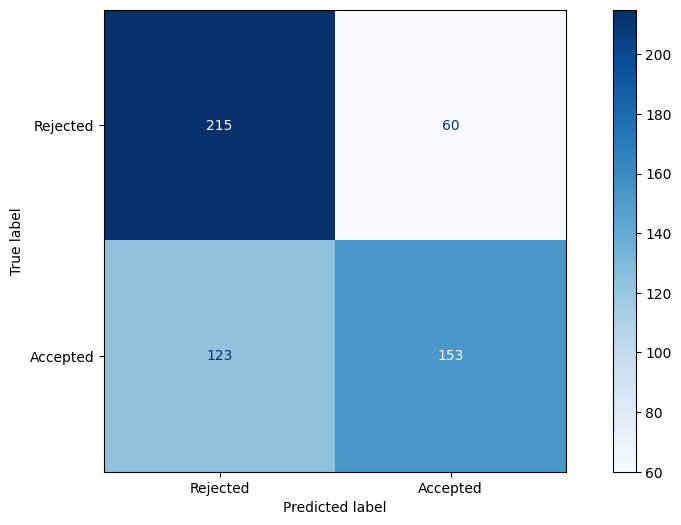

  Validation Accuracy: 0.67
Validation Loss: 1.77
Validation took: 0:00:18

Training complete!
Total training took 0:36:51 (h:mm:ss)


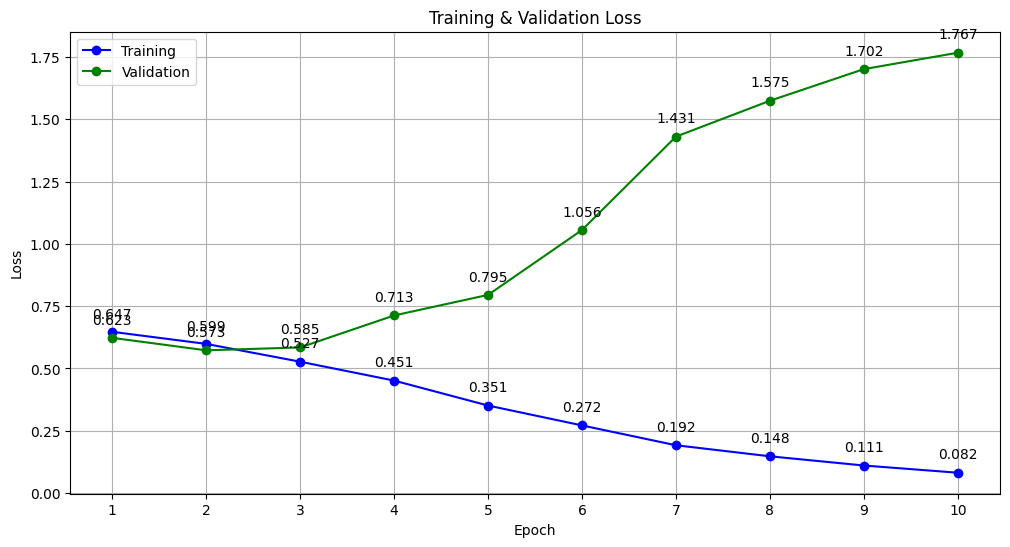

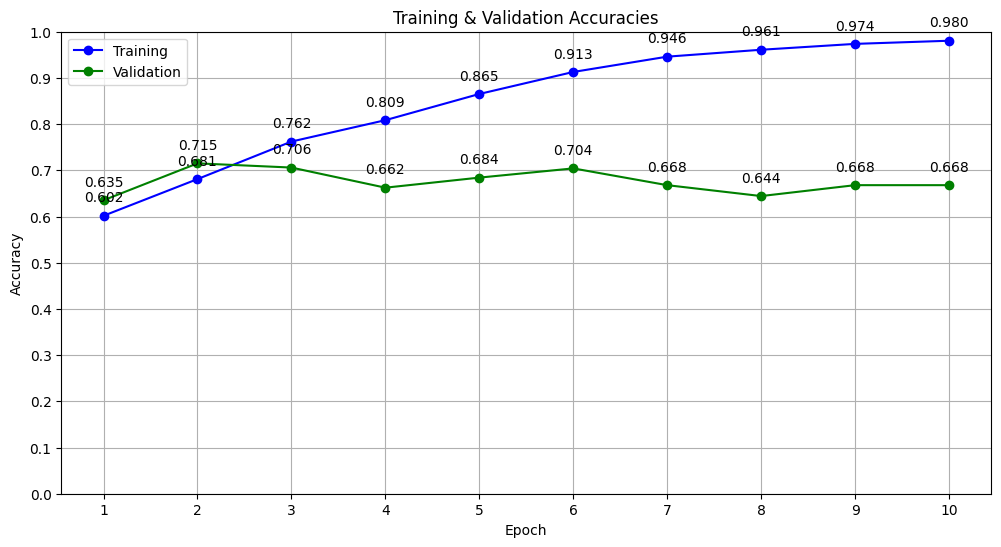

================ Ensemble model #2 ================


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/1380 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.68
  Training epoch took: 0:03:24
  Training Accuracy: 0.57

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.68
Validation took: 0:00:18

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.70
  Training epoch took: 0:03:23
  Training Accuracy: 0.49

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.70
Validation took: 0:00:17

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.70
  Training epoch took: 0:03:23
  Training Accuracy: 0.50

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.69
Validation took: 0:00:17

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.70
  Training epoch took: 0:03:23
  Training Accuracy: 0.49

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.70
Validation took: 0:00:17

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.70


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


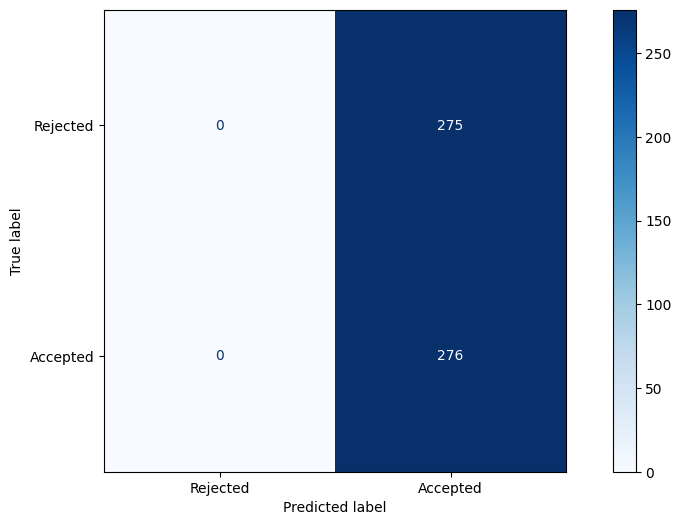

  Validation Accuracy: 0.50
Validation Loss: 0.69
Validation took: 0:00:17

Training complete!
Total training took 0:36:42 (h:mm:ss)


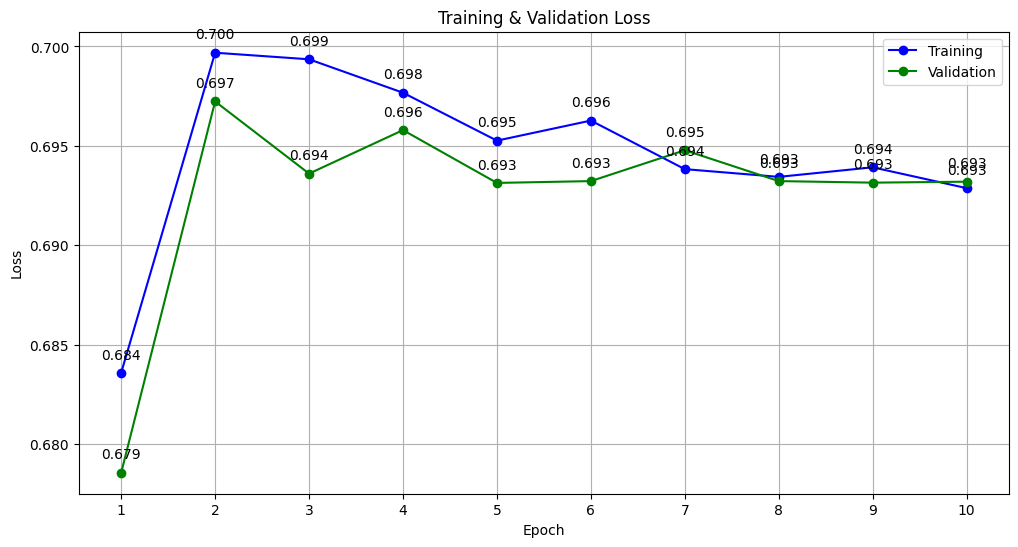

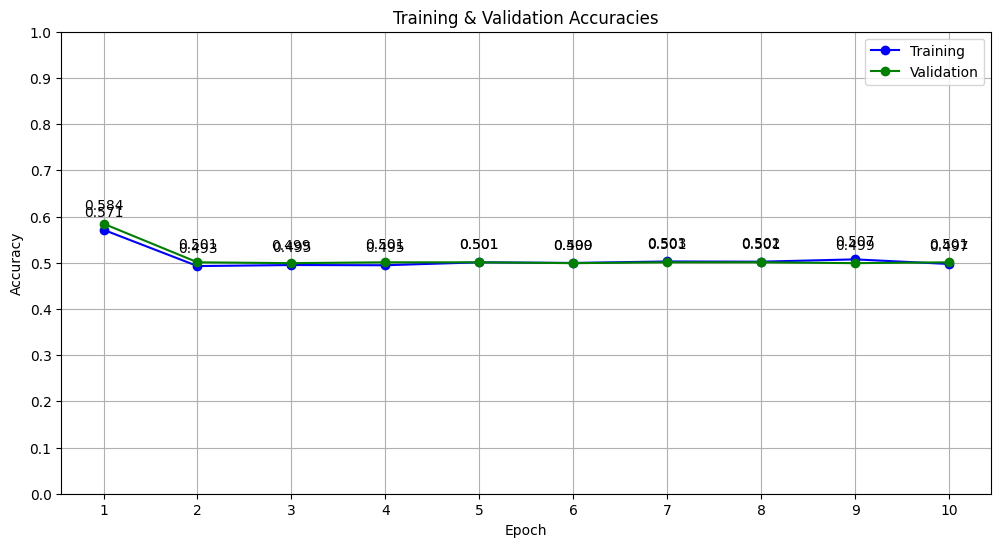

Display Ensemble validation performance metrics after training 2 models
Model Performance metrics:

Accuracy: 0.6661
Precision: 0.7150
Recall: 0.5543
F1 Score: 0.6245


Model Classification report:
              precision    recall  f1-score   support

           0     0.6350    0.7782    0.6993       275
           1     0.7150    0.5543    0.6245       276

    accuracy                         0.6661       551
   macro avg     0.6750    0.6663    0.6619       551
weighted avg     0.6751    0.6661    0.6619       551



Prediction Confusion Matrix:


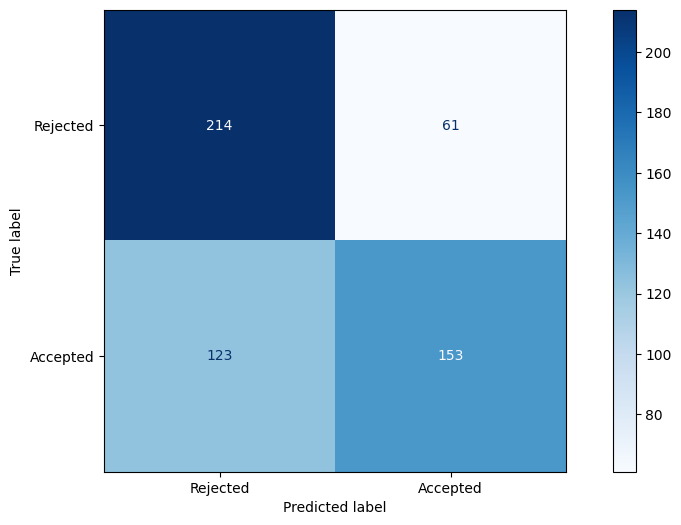

In [11]:
model_eval_accuracies, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models = train_ensemble_models(number_of_models, model_name, tokenizer, training_documents, training_labels, val_documents,
                                                                                                                                                                                 val_labels, batch_size, learning_rate, weight_decay, epochs, device, MAX_TOKENS_NUMBER, 
                                                                                                                                                                                 ensemble_path, random_state)


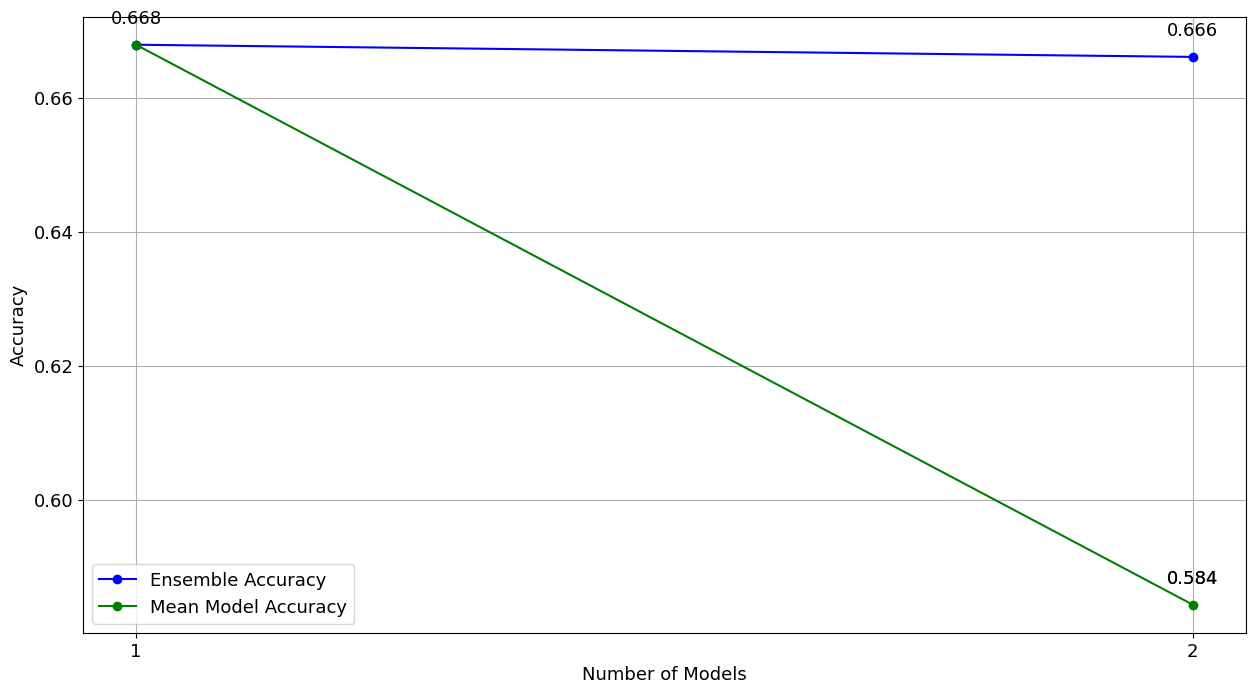

Model 1 accuracy: 66.79%
Model 2 accuracy: 50.09%

Mean models accuracy: 58.44% +- 8.35%


In [12]:
plot_ensemble_accuracy_per_number_of_models(number_of_models, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models)
show_ensemble_model_accuracies(model_eval_accuracies)

# Testing the Ensemble of Models

All models are tested for the test set both individually and as the ensemble.

Model Performance metrics:

Accuracy: 0.6662
Precision: 0.6827
Recall: 0.6192
F1 Score: 0.6494


Model Classification report:
              precision    recall  f1-score   support

           0     0.6525    0.7130    0.6814       345
           1     0.6827    0.6192    0.6494       344

    accuracy                         0.6662       689
   macro avg     0.6676    0.6661    0.6654       689
weighted avg     0.6676    0.6662    0.6654       689



Prediction Confusion Matrix:


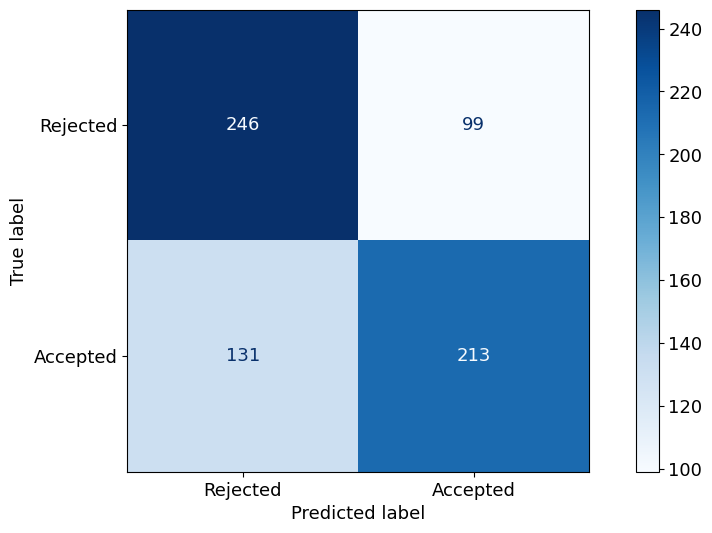


Ensemble performance: 66.62%
Model Performance metrics:

Accuracy: 0.4993
Precision: 0.4993
Recall: 1.0000
F1 Score: 0.6660


Model Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       345
           1     0.4993    1.0000    0.6660       344

    accuracy                         0.4993       689
   macro avg     0.2496    0.5000    0.3330       689
weighted avg     0.2493    0.4993    0.3325       689



Prediction Confusion Matrix:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


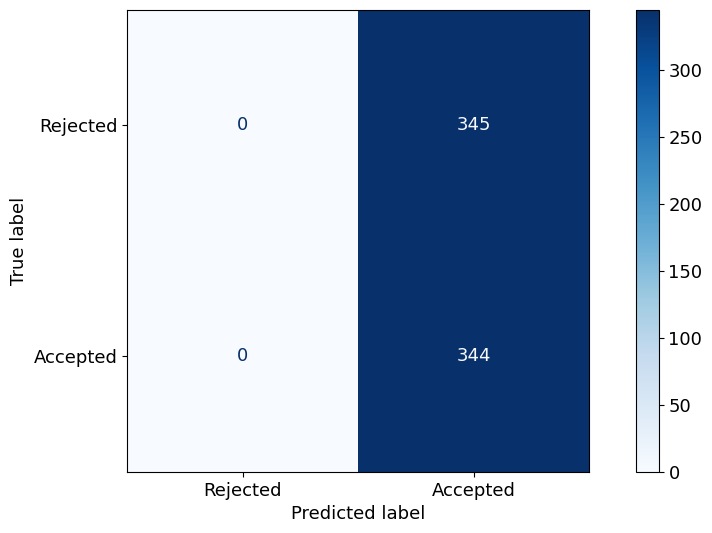


Ensemble performance: 66.76%

Display Ensemble test performance metrics after training 2 models
Model Performance metrics:

Accuracy: 0.6676
Precision: 0.6837
Recall: 0.6221
F1 Score: 0.6514


Model Classification report:
              precision    recall  f1-score   support

           0     0.6543    0.7130    0.6824       345
           1     0.6837    0.6221    0.6514       344

    accuracy                         0.6676       689
   macro avg     0.6690    0.6676    0.6669       689
weighted avg     0.6690    0.6676    0.6669       689



Prediction Confusion Matrix:


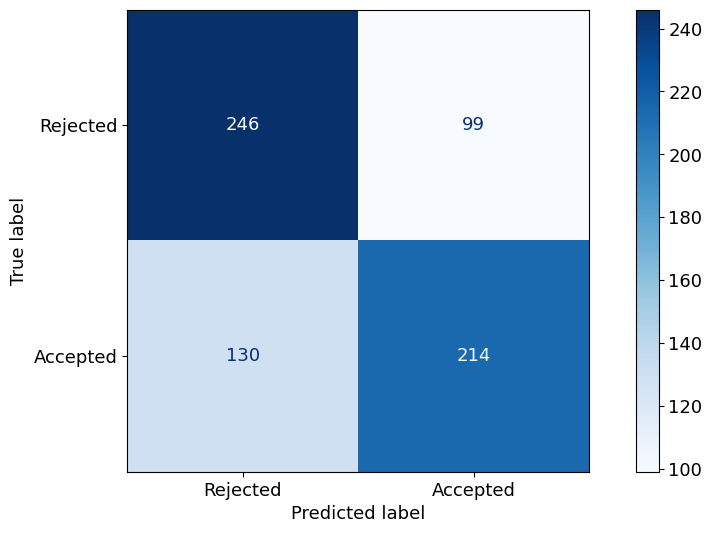

In [13]:
model_test_accuracies, ensemble_test_performance_on_number_of_models, models_mean_test_performance_on_number_of_models, models_std_test_performance_on_number_of_models = test_ensemble_models(number_of_models, tokenizer, model_name, testing_documents, 
                                                                                                                                                                                               testing_labels, learning_rate, weight_decay, batch_size, 
                                                                                                                                                                                               device, MAX_TOKENS_NUMBER, ensemble_path)


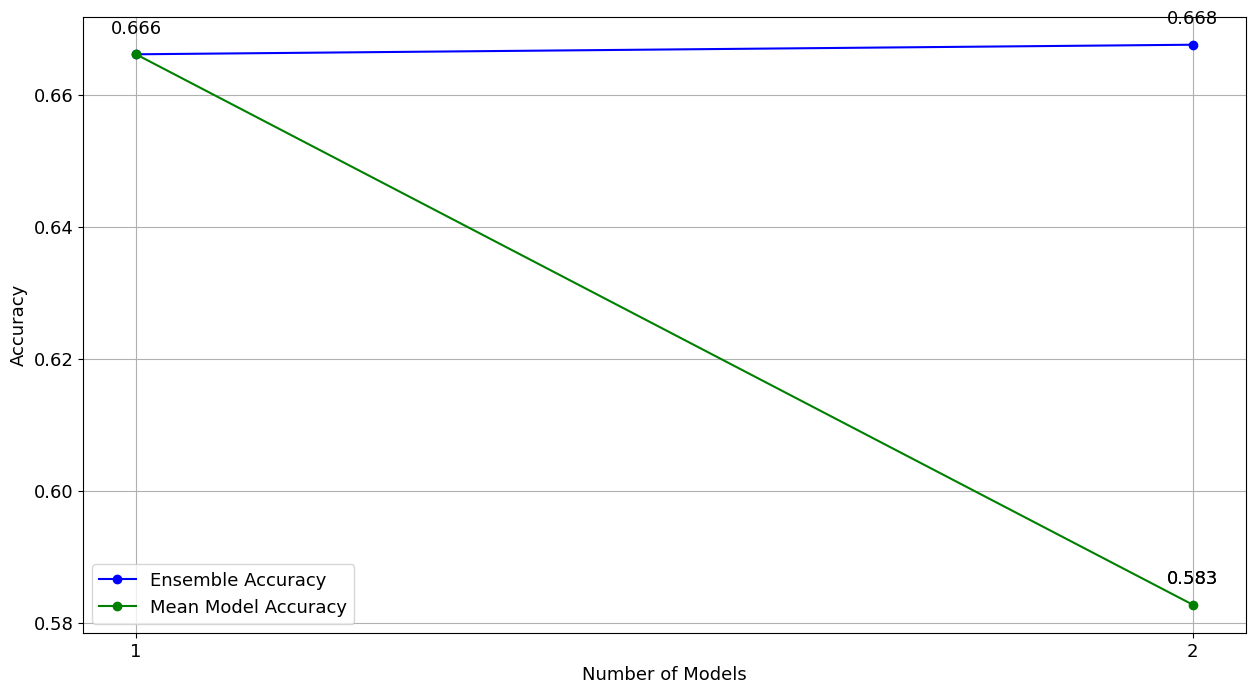

Model 1 accuracy: 66.62%
Model 2 accuracy: 49.93%

Mean models accuracy: 58.27% +- 8.35%


In [14]:
plot_ensemble_accuracy_per_number_of_models(number_of_models, ensemble_test_performance_on_number_of_models, models_mean_test_performance_on_number_of_models, models_std_test_performance_on_number_of_models)
show_ensemble_model_accuracies(model_test_accuracies)